### Importing libraries

In [113]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import shap
import warnings
warnings.filterwarnings('ignore')

### **1. Finalizing Model Evaluation**

### Making sure that the best performing model is saved

In [114]:
if os.path.exists('../Models/best_model.pkl'):
    import joblib
    best_model = joblib.load('../Models/best_model.pkl')

print("Best model loaded successfully.")

Best model loaded successfully.


### Model Analysis: Strengths & Weaknesses

#### **Rank 1: Decision Tree**

**Strengths:**
  - Best overall accuracy (94.2%) and F1 score (94.3%), showing a strong balance of precision and recall.
  - Simple to interpret and visualize
  - Fast to train and performs well even without extensive hyperparameter tuning.

**Weaknesses:**
  - Slightly lower ROC-AUC (0.85) than Random Forest → might not separate classes as cleanly in probabilistic terms.
  - Prone to overfitting, especially if not pruned.



#### **Rank 2: Random Forest**

**Strengths:**
  - Highest ROC-AUC (0.90) → indicates excellent class separability.
  - More robust to overfitting than Decision Trees due to ensembling.
  - Consistently strong across all metrics — a very reliable all-rounder.

**Weaknesses**:
  - Slightly lower accuracy/F1 than Decision Tree in this specific dataset.
  - Harder to interpret natively — use SHAP for model explainability.



#### **Rank 3: Support Vector Machine (SVM)**
**Strengths**:
  - Surprisingly high precision (85.9%), meaning it makes fewer false positive errors.
  - Could still be useful if recall is not a major concern.
**Weaknesses**:
  - Very low recall (56%) and F1 score (66%), suggesting it's not capturing most of the correct cases.
  - Poor generalization (low cross-validation accuracy).
  - Sensitive to feature scaling and class imbalance.


#### **Rank 4: Logistic Regression**
**Strengths**:
  - High precision (82.4%) → good when false positives are costly.
  - Simple, fast, and interpretable model.
**Weaknesses**:
  - Lowest overall accuracy (40.7%), recall, and F1 score.
  - Performs poorly on complex, nonlinear patterns — not suitable for this dataset without major feature engineering.

#### **Final Model Choice: Decision Tree**

Chosen due to:
- Best overall classification performance (F1 score, accuracy)
- Easy interpretability
- Minimal drop in ROC-AUC compared to Random Forest

#### Check in **Modelling.ipynb** 
You will find:
- Comparison between all the models on the basis of accuracy, precision, recall, f1-score, cv-accuracy, and roc-auc
- Confusion matrix for Decision Tree
- ROC curve for Decision Tree

### **2. Model Interpretation**

#### Finding Feature Importance post PCA

In [129]:
X_pca = pd.read_csv('../Data/x_pca.csv')
y = pd.read_csv('../Data/y.csv')

#### 1. Random Forest Selector

In [130]:
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_pca, y)
top_rf = pd.DataFrame({
'Feature': X_pca.columns,
'Importance': rf_selector.feature_importances_
})

top_rf = top_rf.sort_values(by='Importance', ascending=False).head(10)
top_rf

,Feature,Importance
0,PC1,0.341608
2,PC3,0.334490
1,PC2,0.323902


#### 2. Mutual Info Classifier

In [131]:
mi_scores = mutual_info_classif(X_pca, y, random_state=42)
feature_importance_mi = pd.DataFrame({
    'Feature': X_pca.columns,
    'MI_Score': mi_scores
})

feature_importance_mi = feature_importance_mi.sort_values(by='MI_Score', ascending=False).head(10)
feature_importance_mi

,Feature,MI_Score
1,PC2,0.340792
2,PC3,0.275249
0,PC1,0.274608


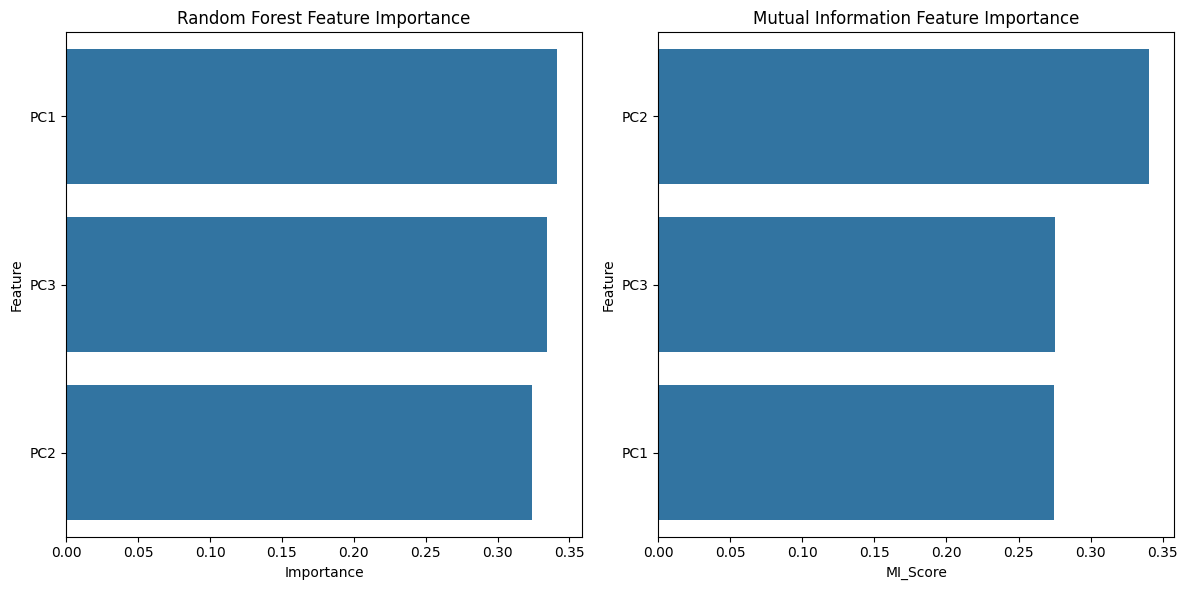

In [121]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=top_rf)
plt.title('Random Forest Feature Importance')

plt.subplot(1, 2, 2)
sns.barplot(x='MI_Score', y='Feature', data=feature_importance_mi)
plt.title('Mutual Information Feature Importance')

plt.tight_layout()
plt.show()

#### Combining the best features from both the methodologies

In [123]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

top_rf['Importance_Norm'] = scaler.fit_transform(top_rf[['Importance']])
feature_importance_mi['MI_Score_Norm'] = scaler.fit_transform(feature_importance_mi[['MI_Score']])

combined_features = pd.merge(top_rf, feature_importance_mi, on='Feature', how='inner')

combined_features['Combined_Score'] = (combined_features['Importance_Norm'] + combined_features['MI_Score_Norm']) / 2

combined_features = combined_features.sort_values(by='Combined_Score', ascending=False)


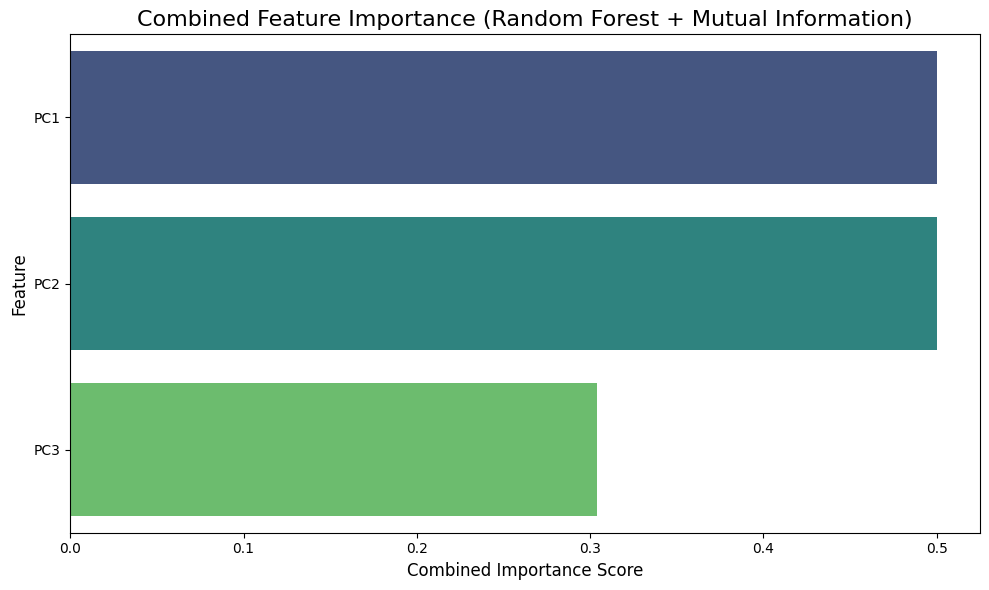

In [124]:

plt.figure(figsize=(10, 6))
sns.barplot(x='Combined_Score', y='Feature', data=combined_features, palette='viridis')

plt.title('Combined Feature Importance (Random Forest + Mutual Information)', fontsize=16)
plt.xlabel('Combined Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)

plt.tight_layout()
plt.show()

#### SHAP Explanations

In [125]:
import joblib

best_model = joblib.load('../Models/best_model.pkl')

In [126]:
X_test = pd.read_csv('../Data/x_test.csv')
X_test.columns = ['PC1', 'PC2', 'PC3']

In [127]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

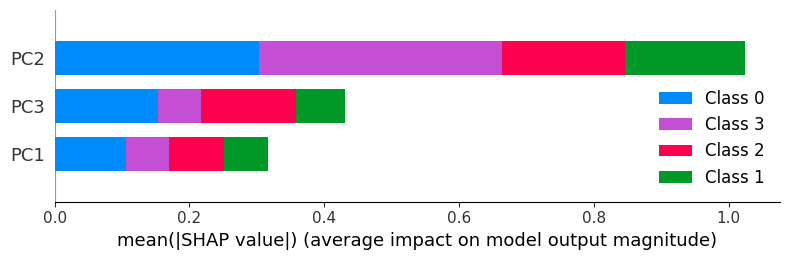

In [128]:
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)